In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [5]:
df = pd.read_csv('clean_tweets.csv')

In [6]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['sentiment'] = df['sentiment'].map({0:0,4:1})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
sentiment    1600000 non-null int64
text         1596714 non-null object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [8]:
df.dropna(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1596714 entries, 0 to 1599999
Data columns (total 2 columns):
sentiment    1596714 non-null int64
text         1596714 non-null object
dtypes: int64(1), object(1)
memory usage: 36.5+ MB


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x = df['text'] #define all other columns except the target variable
y = df['sentiment'] #define the target variable

x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size = 0.02, random_state = 42)

x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, 
                                                              test_size = 0.5, random_state = 42)

## Feature Extraction Using TF-IDF

**Term Frequency** measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length or the total number of terms in the document as a way of normalization: 

$$TF(t) = \frac{\text{Number of times term t appears in a document}}{\text{Total number of terms in the document}}$$

**Inverse Document Frequency** measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

$$IDF(t) = \log_e{\frac{\text{Total number of documents}} {\text{Number of documents with term t in it}}}$$

Combining these two, we get TF-IDF.

$$TF-IDF(t) = {TF(t)}\times{IDF(t)}$$

The higher the TFIDF score, the rarer the term and vice versa.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
null_accuracy = 0
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test==0])/len(x_test)>0.5:
        null_accuracy = len(x_test[y_test==0])/len(x_test)
    else:
        null_accuracy = 1 - len(x_test[y_test==0])/len(x_test)
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("Null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("Accuracy: {0:.2f}%".format(accuracy*100))
    if accuracy>null_accuracy:
        print("Model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy==null_accuracy:
        print("Model has the same accuracy as null accuracy")
    else:
        print("Model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("Train and test time: {0:.2f}s".format(train_test_time))
    print("-"*50)
    return accuracy, train_test_time

In [14]:
tfidf = TfidfVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000, 100001, 10000)

In [15]:
def nfeature_accuracy_checker(vectorizer = tfidf, n_features = n_features, stop_words = None, 
                              ngram_range = (1,1), classifier = lr):
    result = []
    print(classifier, "\n")
    for n in n_features:
        vectorizer.set_params(stop_words = stop_words, max_features = n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])
        print("Validation result for {0} features".format(n))
        nfeature_accuracy, ttime = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n, nfeature_accuracy, ttime))
    return result

In [18]:
%%time
print("RESULT FOR UNIGRAM\n")
feature_result_ug_t = nfeature_accuracy_checker()

RESULT FOR UNIGRAM

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Validation result for 10000 features
Null accuracy: 50.18%
Accuracy: 79.60%
Model is 29.41% more accurate than null accuracy
Train and test time: 59.01s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 50.18%
Accuracy: 79.87%
Model is 29.69% more accurate than null accuracy
Train and test time: 54.30s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 50.18%
Accuracy: 79.90%
Model is 29.72% more accurate than null accuracy
Train and test time: 68.17s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 50.18%
Accuracy: 80.00%
Model is 29.82% more accur

In [21]:
%%time
print("RESULT FOR BIGRAM\n")
feature_result_bg_t = nfeature_accuracy_checker(ngram_range=(1,2))

RESULT FOR BIGRAM

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Validation result for 10000 features
Null accuracy: 50.18%
Accuracy: 80.54%
Model is 30.36% more accurate than null accuracy
Train and test time: 167.01s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 50.18%
Accuracy: 81.59%
Model is 31.41% more accurate than null accuracy
Train and test time: 175.60s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 50.18%
Accuracy: 81.74%
Model is 31.55% more accurate than null accuracy
Train and test time: 185.52s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 50.18%
Accuracy: 82.06%
Model is 31.88% more acc

In [23]:
%%time
print("RESULT FOR TRIGRAM\n")
feature_result_tg_t = nfeature_accuracy_checker(ngram_range=(1,3))

RESULT FOR TRIGRAM

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False) 

Validation result for 10000 features
Null accuracy: 50.18%
Accuracy: 80.42%
Model is 30.23% more accurate than null accuracy
Train and test time: 362.89s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 50.18%
Accuracy: 81.40%
Model is 31.21% more accurate than null accuracy
Train and test time: 337.88s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 50.18%
Accuracy: 81.67%
Model is 31.48% more accurate than null accuracy
Train and test time: 387.06s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 50.18%
Accuracy: 81.89%
Model is 31.71% more ac

In [24]:
feature_plot_ug_t = pd.DataFrame(feature_result_ug_t, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_bg_t = pd.DataFrame(feature_result_bg_t, columns=['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_tg_t = pd.DataFrame(feature_result_tg_t, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])

In [36]:
feature_plot_ug_c = pd.read_csv('ug-with-stopwords.csv', index_col=[0])
feature_plot_bg_c = pd.read_csv('bg.csv', index_col=[0])
feature_plot_tg_c = pd.read_csv('tg.csv', index_col=[0])

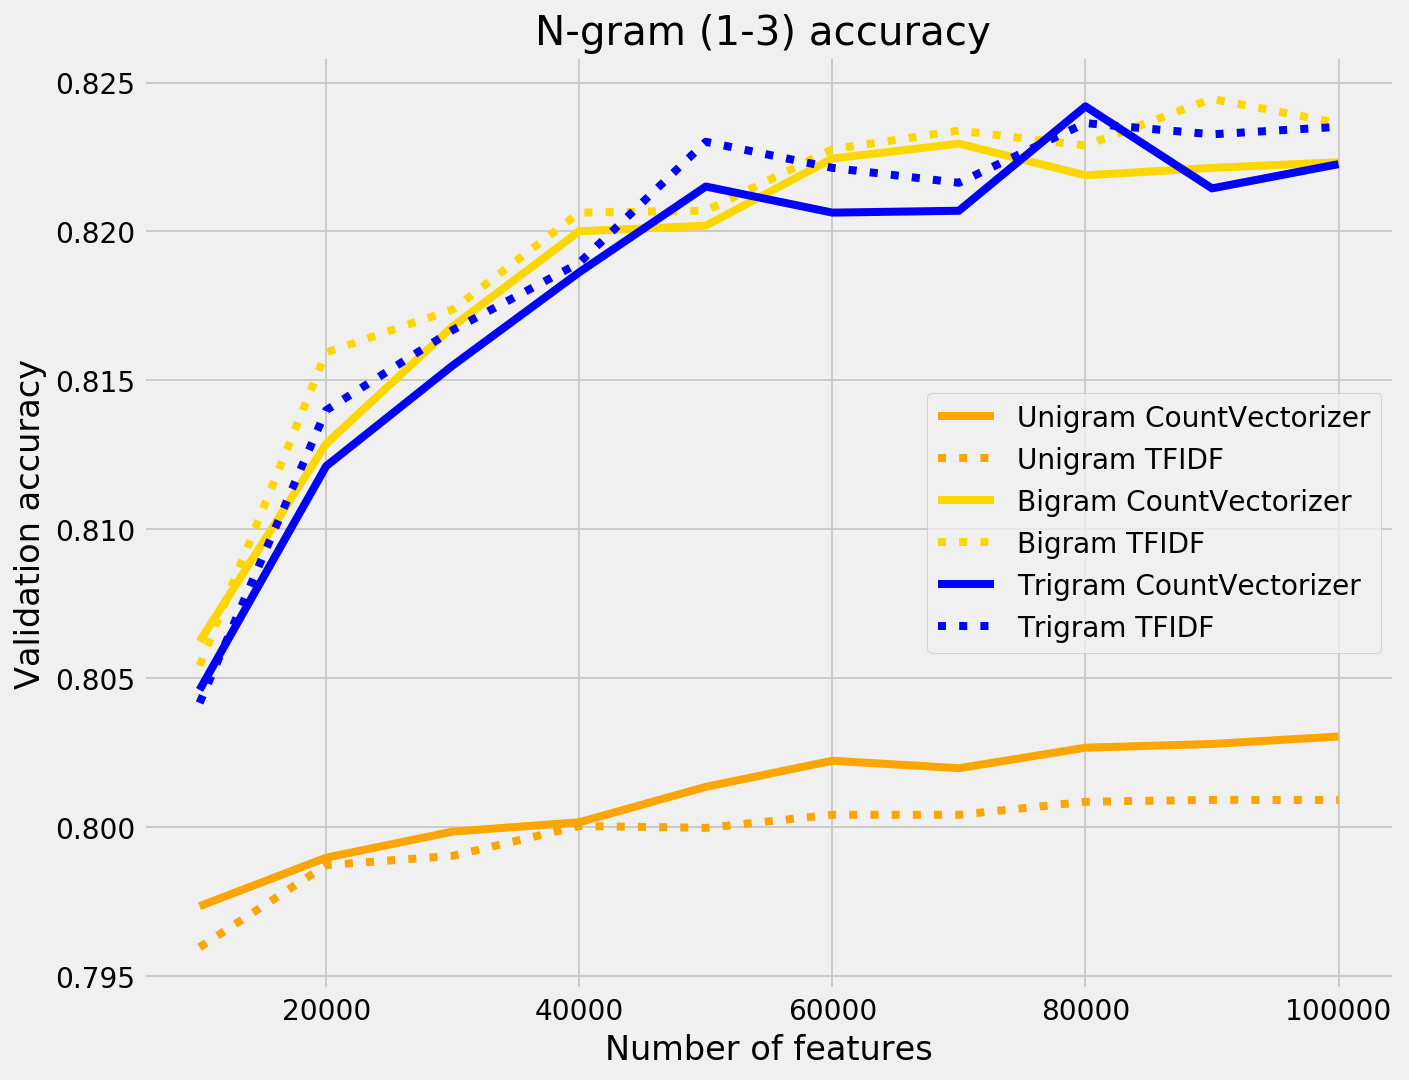

In [38]:
plt.figure(figsize=(10, 8))
plt.plot(feature_plot_ug_c.nfeatures, feature_plot_ug_c.validation_accuracy, label='Unigram CountVectorizer', color='orange')
plt.plot(feature_plot_ug_t.nfeatures, feature_plot_ug_t.validation_accuracy, label='Unigram TFIDF', linestyle=':', color='orange')
plt.plot(feature_plot_bg_c.nfeatures, feature_plot_bg_c.validation_accuracy, label='Bigram CountVectorizer', color='gold')
plt.plot(feature_plot_bg_t.nfeatures, feature_plot_bg_t.validation_accuracy, label='Bigram TFIDF', linestyle=':', color='gold')
plt.plot(feature_plot_tg_c.nfeatures, feature_plot_tg_c.validation_accuracy, label='Trigram CountVectorizer', color='blue')
plt.plot(feature_plot_tg_t.nfeatures, feature_plot_tg_t.validation_accuracy, label='Trigram TFIDF', linestyle=':', color='blue')
plt.title('N-gram (1-3) accuracy ')
plt.xlabel('Number of features')
plt.ylabel('Validation accuracy')
plt.legend()

Hence, we can clearly see that using bigram and trigrams boosts the performance of the model in CountVectorizer and TfidfVectorizer both. Also, for bigram and trigram, TfidfVectorizer gives better performance than CountVectorizer.

Bigram TfidfVectorizer at 90000 features gives the highest validation accuracy at 82.45%.

## Algorithms Comparison

In [21]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [22]:
names = ['Ridge Classifier', 'Logistic Regression', 'Perceptron', 'Passive-Agressive Classifier', 'Stochastic Gradient Descent',
         'LinearSVC', 'L1 based LinearSVC', 'KNN', 'Nearest Centroid', 'Multinomial NB', 'Bernoulli NB', 'Adaboost']
classifiers = [
    RidgeClassifier(),
    LogisticRegression(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    SGDClassifier(),
    LinearSVC(),
    Pipeline([
        ('feature_selection', SelectFromModel(LinearSVC(penalty='l1', dual=False))),
        ('classification', LinearSVC(penalty='l2'))
    ]),
    KNeighborsClassifier(),
    NearestCentroid(),
    MultinomialNB(),
    BernoulliNB(),
    AdaBoostClassifier(),
]

In [23]:
zipped_clf = zip(names, classifiers)
tfidf = TfidfVectorizer()

In [24]:
def classifier_comparator(vectorizer = tfidf, n_features=10000, stop_words=None, ngram_range=(1,1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range, max_features=n_features)
    for n, c in classifier:
        pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', c)])
        print('Validation result for {}'.format(n), c)
        clf_accuracy, ttime = accuracy_summary(pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n, clf_accuracy, ttime))
    return result

In [25]:
bigram_comparison = classifier_comparator(n_features=90000, ngram_range=(1,2))

Validation result for Ridge Classifier RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
Null accuracy: 50.18%
Accuracy: 82.30%
Model is 32.12% more accurate than null accuracy
Train and test time: 180.80s
--------------------------------------------------
Validation result for Logistic Regression LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 82.45%
Model is 32.26% more accurate than null accuracy
Train and test time: 184.68s
--------------------------------------------------
Validation result for Perceptron Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 76.26%
Model is 26.08% more accurate than null accuracy
Train and test time: 114.74s
--------------------------------------------------
Validation result for Passive-Agressive Classifier PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 79.57%
Model is 29.39% more accurate than null accuracy
Train and test time: 113.99s
--------------------------------------------------
Validation result for Stochastic Gradient Descent SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Null accuracy: 50.18%
Accuracy: 78.66%
Model is 28.48% more accurate than null accuracy
Train and test time: 114.96s
--------------------------------------------------
Validation result for LinearSVC LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Null accuracy: 50.18%
Accuracy: 82.41%
Model is 32.23% more accurate than null accuracy
Train and test time: 784.64s
--------------------------------------------------
Validation result for L1 based LinearSVC Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
        max_features=None, n...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])


C:\Users\dell\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Null accuracy: 50.18%
Accuracy: 82.30%
Model is 32.12% more accurate than null accuracy
Train and test time: 977.12s
--------------------------------------------------
Validation result for KNN KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
Null accuracy: 50.18%
Accuracy: 61.86%
Model is 11.67% more accurate than null accuracy
Train and test time: 2190.19s
--------------------------------------------------
Validation result for Nearest Centroid NearestCentroid(metric='euclidean', shrink_threshold=None)
Null accuracy: 50.18%
Accuracy: 72.55%
Model is 22.36% more accurate than null accuracy
Train and test time: 66.09s
--------------------------------------------------
Validation result for Multinomial NB MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Null accuracy: 50.18%
Accuracy: 80.15%
Model is 29.97% more accurate than null accuracy
Train and test time: 